# Sentiment Analysis 3 Capres pada Pemilu tahun 2024 di Indonesia Berdasarkan Sosial Media X (Formerly Twitter)

## Crawl Data

In [ ]:
# Install Node.js
!sudo apt-get update
!sudo apt-get install -y ca-certificates curl gnupg
!sudo mkdir -p /etc/apt/keyrings
!curl -fsSL https://deb.nodesource.com/gpgkey/nodesource-repo.gpg.key | sudo gpg --dearmor -o /etc/apt/keyrings/nodesource.gpg

!NODE_MAJOR=20 && echo "deb [signed-by=/etc/apt/keyrings/nodesource.gpg] https://deb.nodesource.com/node_$NODE_MAJOR.x nodistro main" | sudo tee /etc/apt/sources.list.d/nodesource.list

!sudo apt-get update
!sudo apt-get install nodejs -y

!node -v

In [ ]:
# Crawl Data
twitter_auth_token = 'xxx'
filename = 'nama_file.csv'
search_keyword = 'keyword lang:id until:2023-10-28 since:2023-10-22'
limit = 5000

!npx --yes tweet-harvest@2.2.8 -o "{filename}" -s "{search_keyword}" -l {limit} --token {twitter_auth_token}

## Load Dataset Train

In [9]:
import pandas as pd

data_train = pd.read_csv('https://gist.githubusercontent.com/redoti/ab05e041ac3638c1744309d1897c8681/raw/7bc092e6a9e44f870565d5f8835bdffeed1be348/juli2train.csv')

# 1 = positive & 0 = negative
display(data_train.head())
data_train.info()

,label,tweet
0,1,rt @napqilla no ambisinya menguasai raky...
1,1,rt @pandji nah gue pikir sentimen petahana ok...
2,1,rt @pandji urutan pertama best moment #debat ...
3,1,rt @pandji ini artikel yg menjelaskan ternyat...
4,0,rt @mrtampi agus makin santai nahok makin sa...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1050 non-null   int64 
 1   tweet   1050 non-null   object
dtypes: int64(1), object(1)
memory usage: 16.5+ KB


([0, 1], [Text(0, 0, '0'), Text(1, 0, '1')])

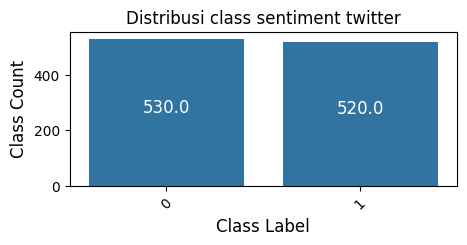

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count total review positive and negative
plt.figure(figsize=(5,2))
ax = sns.countplot(x='label', data=data_train)
# Add annotations (counts) to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()/2), ha='center', fontsize=12, color='white')
plt.title('Distribusi class sentiment twitter', fontsize=12)
plt.ylabel('Class Count', fontsize=12)
plt.xlabel('Class Label', fontsize=12)
plt.xticks(rotation=45)

## Data Preprocessing (Data Training)

### 1. Remove Punctuation using Regex

In [11]:
# Remove Punctuation
import re

def clean_tweet(tweet):

    # Remove 'rt @user'
    tweet = re.sub(r'rt\s+@[\w_]+', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)

    # Remove URL
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)

    # Remove special characters
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)

    # Remove double space
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    # Remove prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', tweet)

    # Convert to Lowercase
    processed_tweet = processed_tweet.lower()

    return tweet

# Apply Remove Punctuation
data_train['clean_tweet'] = data_train['tweet'].apply(clean_tweet)

data_train.head(2)

,label,tweet,clean_tweet
0,1,rt @napqilla no ambisinya menguasai raky...,no ambisinya menguasai rakyat no ambisinya mel...
1,1,rt @pandji nah gue pikir sentimen petahana ok...,nah gue pikir sentimen petahana oke di debat p...


### 2. Tokenizing using NLTK

In [12]:
# Tokenizing

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def tokenize(text):
    # Tokenize the words in the text using NLTK
    tokens = word_tokenize(text)
    return tokens

# Apply Tokenizing
data_train['clean_tweet'] = data_train['clean_tweet'].apply(tokenize)

data_train.head(2)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\redot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,label,tweet,clean_tweet
0,1,rt @napqilla no ambisinya menguasai raky...,"[no, ambisinya, menguasai, rakyat, no, ambisin..."
1,1,rt @pandji nah gue pikir sentimen petahana ok...,"[nah, gue, pikir, sentimen, petahana, oke, di,..."


### 3. Remove Stopword English and Bahasa Indonesia using NLTK (ENG) and Sastrawi (ID)

In [13]:
# Remove Stopword English
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_stopwords_eng(word_list):
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in word_list if word.lower() not in stop_words]
    return filtered_words

# Apply Remove Stopword English
data_train['clean_tweet'] = data_train['clean_tweet'].apply(remove_stopwords_eng)

data_train.head(2)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\redot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,tweet,clean_tweet
0,1,rt @napqilla no ambisinya menguasai raky...,"[ambisinya, menguasai, rakyat, ambisinya, mela..."
1,1,rt @pandji nah gue pikir sentimen petahana ok...,"[nah, gue, pikir, sentimen, petahana, oke, di,..."


In [14]:
# Remove Stopword Indonesia

# Import Sastrawi
#!pip instal Sastrawi # Karena saya mengerjakannya di lokal dan sudah terinstall
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Initialize
stopword_factory = StopWordRemoverFactory()
stopword = stopword_factory.create_stop_word_remover()

def remove_stopwords_id(word_list):
    # Remove Stopword
    return stopword.remove(' '.join(word_list)).split()

# Apply Remove Stopword Indonesia
data_train['clean_tweet'] = data_train['clean_tweet'].apply(remove_stopwords_id)

data_train.head(2)

,label,tweet,clean_tweet
0,1,rt @napqilla no ambisinya menguasai raky...,"[ambisinya, menguasai, rakyat, ambisinya, mela..."
1,1,rt @pandji nah gue pikir sentimen petahana ok...,"[nah, gue, pikir, sentimen, petahana, oke, deb..."


### 4. Stemming using Sastrawi

In [15]:
# Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Initialize
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

def stem_text(word_list):
    word_list = ' '.join(word_list)  
    return stemmer.stem(word_list)

# Apply Stemming
data_train['clean_tweet'] = data_train['clean_tweet'].apply(stem_text)
data_train.head(2)

,label,tweet,clean_tweet
0,1,rt @napqilla no ambisinya menguasai raky...,ambisi kuasa rakyat ambisi layan rakyat lihat ...
1,1,rt @pandji nah gue pikir sentimen petahana ok...,nah gue pikir sentimen tahana oke debat pilkad...


In [16]:
# Create a new dataframe
data_clean = data_train.copy()
data_clean = data_clean.drop('tweet', axis=1)

data_clean = data_clean.astype({'label' : 'category'})
data_clean = data_clean.astype({'clean_tweet' : 'string'})
# Switch the column order
data_clean = data_clean[['clean_tweet', 'label']]
display(data_clean.head(2))
display(data_clean.dtypes)

,clean_tweet,label
0,ambisi kuasa rakyat ambisi layan rakyat lihat ...,1
1,nah gue pikir sentimen tahana oke debat pilkad...,1


clean_tweet    string[python]
label                category
dtype: object

Checkpoint

In [17]:
# Save the clean dataset to csv
data_clean.to_csv('data_train_clean.csv', index=False)

In [18]:
import pandas as pd
data_clean = pd.read_csv('D:\SIB Orbit\mini project NLP\data_train_clean.csv')

### 5. Vectorizer using TF-IDF

In [19]:
# Vectorizer TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

func_tfidf = TfidfVectorizer()
text_tfidf = func_tfidf.fit_transform(data_clean['clean_tweet'].astype('U'))
text_tfidf

<1050x2858 sparse matrix of type '<class 'numpy.float64'>'
	with 13256 stored elements in Compressed Sparse Row format>

### 6. Splitting to Data Train and Data Test

In [20]:
# Splitting data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(text_tfidf,            # Features
                                                    data_clean['label'],   # Label
                                                    test_size=0.2, 
                                                    random_state = 42)

## Modelling using Support Vector Machine (SVM)

Setelah dilakukan test dengan model lain, yang paling bagus adalah SVM ini

In [21]:
# SVM
from sklearn.svm import SVC

text_classifier_svm = SVC(kernel='linear')
text_classifier_svm.fit(X_train, y_train)

predictions_svm = text_classifier_svm.predict(X_test)


In [22]:
# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

print("Support Vector Machine Train")
print('Accuracy train  = ', round(accuracy_score(y_train, text_classifier_svm.predict(X_train))*100,2),'%')
print('Recall train   = ', round(recall_score(y_train, text_classifier_svm.predict(X_train))*100,2),'%')
print('Precision train= ', round(precision_score(y_train, text_classifier_svm.predict(X_train))*100,2),'%')
print('F1-Score train = ', round(f1_score(y_train, text_classifier_svm.predict(X_train))*100,2),'%')
print('ROC AUC train  = ', roc_auc_score(y_train, text_classifier_svm.predict(X_train)))
print()
print("Support Vector Machine Test")
print('Accuracy test = ', round(accuracy_score(y_test, predictions_svm)*100,2),'%')
print('Recall  test  = ', round(recall_score(y_test, predictions_svm)*100,2),'%')
print('Precision test = ', round(precision_score(y_test, predictions_svm)*100,2),'%')
print('F1-Score test = ', round(f1_score(y_test, predictions_svm)*100,2),'%')
print('ROC AUC test  = ', roc_auc_score(y_test, predictions_svm))
print()
print('confusion Matrix')
print(confusion_matrix(y_test,predictions_svm))
print(classification_report(y_test,predictions_svm))

Support Vector Machine Train
Accuracy train  =  94.52 %


Recall train   =  96.59 %
Precision train=  92.54 %
F1-Score train =  94.52 %
ROC AUC train  =  0.9456723325336465

Support Vector Machine Test
Accuracy test =  82.38 %
Recall  test  =  89.91 %
Precision test =  79.03 %
F1-Score test =  84.12 %
ROC AUC test  =  0.820828413116541

confusion Matrix
[[75 26]
 [11 98]]
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       101
           1       0.79      0.90      0.84       109

    accuracy                           0.82       210
   macro avg       0.83      0.82      0.82       210
weighted avg       0.83      0.82      0.82       210



Predictions

In [23]:
# Example Text
new_text = pd.DataFrame({'new_text': ['kemakan kok sama janji manis tai kucing']})

# Data Preprocessing
new_text['new_text'] = new_text['new_text'].apply(clean_tweet)            # Remove Punctuation
new_text['new_text'] = new_text['new_text'].apply(tokenize)               # Tokenizing
new_text['new_text'] = new_text['new_text'].apply(remove_stopwords_eng)   # Remove ENG Stopword
new_text['new_text'] = new_text['new_text'].apply(remove_stopwords_id)    # Remove ID Stopword
new_text['new_text'] = new_text['new_text'].apply(stem_text)              # Stemming
new_text = [new_text['new_text'][0]]
new_text_tfidf = func_tfidf.transform(new_text)

# Prediction
predictions = text_classifier_svm.predict(new_text_tfidf)


# Output
print("Hasil prediksi:", predictions) # 1 = positive & 0 = negative

new_text


Hasil prediksi: [0]


['makan kok sama janji manis tai kucing']

## Predict the New Data

*Disclaimer* : Karena perbedaan jumlah data yang telah difilter by username, maka dilakukan pemangkasan jumlah data menjadi 2000 per dataset.

### Prabowo

In [24]:
# Load dataset result from Crawl
file_path = 'tweets-data/prabowo_27oct.csv'
rawdf_prabowo = pd.read_csv(file_path, delimiter=";")

rawdf_prabowo.head(2)

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
0,Fri Oct 27 23:59:44 +0000 2023,1718054909386568060,@UmarSyadatHsb__ Semoga bapak @aniesbaswedan t...,0,0,0,0,in,1690797007848566784,1717930597908406304,baladatemp81441,https://twitter.com/baladatemp81441/status/171...
1,Fri Oct 27 23:59:39 +0000 2023,1718054887093862467,@Sandal_jepit77 @kikysaputrii Mana berani dia ...,0,3,0,0,in,1612414557968011269,1717796048259932644,HarryPurba21,https://twitter.com/HarryPurba21/status/171805...


In [25]:
# Make a new dataframe
df_prabowo = pd.DataFrame({'username': rawdf_prabowo['username'],
                          'tweet': rawdf_prabowo['full_text']})
rawdf_prabowo.head(2)

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
0,Fri Oct 27 23:59:44 +0000 2023,1718054909386568060,@UmarSyadatHsb__ Semoga bapak @aniesbaswedan t...,0,0,0,0,in,1690797007848566784,1717930597908406304,baladatemp81441,https://twitter.com/baladatemp81441/status/171...
1,Fri Oct 27 23:59:39 +0000 2023,1718054887093862467,@Sandal_jepit77 @kikysaputrii Mana berani dia ...,0,3,0,0,in,1612414557968011269,1717796048259932644,HarryPurba21,https://twitter.com/HarryPurba21/status/171805...


In [26]:
# Dataframe Preparation

# Remove duplicates username
df_prabowo = df_prabowo.drop_duplicates(subset='username', keep='first')

# Random 2000 data
df_prabowo = df_prabowo.sample(n=2000, random_state=42)

# Reset index
df_prabowo = df_prabowo.reset_index(drop=True)
df_prabowo

,username,tweet
0,setyadi27,@ngabdirojo @liputan6dotcom Potensi stroke tet...
1,Supriyansa55794,"@fajar_vs aku yakin Tenan mas, pa prabowo baka..."
2,HeruUtomoooo,"@ProPsMaluku @prabowo @Gerindra Setuju banget,..."
3,H4T14K4LN4L42,@prabowo @jokowi @PdiperjuanganP Satu perahu a...
4,Sijo_su,"@antaranews saya lengkapi, Rakyat harap Mahfud..."
...,...,...
1995,srisumartie,@AK__aja @mohmahfudmd MD jd wakil GP kok diem ...
1996,CarolineSarah5,@kikysaputrii Emang lu berkualitas?! Jeja lu ...
1997,dota_donny,@sagaraalmer @willsarana Purapura Ga tau Radik...
1998,FauziRestifauzy,"Jelas bro, Publik percaya Ayahbowo Masgibran m..."


In [27]:
# Data Preprocessing
df_prabowo['clean_tweet'] = df_prabowo['tweet'].apply(clean_tweet)                  # Remove Punctuation
df_prabowo['clean_tweet'] = df_prabowo['clean_tweet'].apply(tokenize)               # Tokenizing
df_prabowo['clean_tweet'] = df_prabowo['clean_tweet'].apply(remove_stopwords_eng)   # Remove ENG Stopword
df_prabowo['clean_tweet'] = df_prabowo['clean_tweet'].apply(remove_stopwords_id)    # Remove ID Stopword
df_prabowo['clean_tweet'] = df_prabowo['clean_tweet'].apply(stem_text)              # Stemming

df_prabowo.head(2)

,username,tweet,clean_tweet
0,setyadi27,@ngabdirojo @liputan6dotcom Potensi stroke tet...,potensi stroke tetap pada prabowo bukan hoax 1...
1,Supriyansa55794,"@fajar_vs aku yakin Tenan mas, pa prabowo baka...",aku yakin tenan mas pa prabowo bakal menang kali


In [28]:
# Make a new Dataframe
data_clean_prabowo = df_prabowo.copy()
data_clean_prabowo = data_clean_prabowo.drop(['tweet','username'], axis=1)
data_clean_prabowo = data_clean_prabowo.astype({'clean_tweet' : 'string'})

# Switch column order
data_clean_prabowo = data_clean_prabowo[['clean_tweet']]

# Save to csv
data_clean_prabowo.to_csv('data_clean_prabowo.csv', index=False)

display(data_clean_prabowo.head(2))
display(data_clean_prabowo.dtypes)

,clean_tweet
0,potensi stroke tetap pada prabowo bukan hoax 1...
1,aku yakin tenan mas pa prabowo bakal menang kali


clean_tweet    string[python]
dtype: object

In [29]:
# Prediction

for i in range(0,len(data_clean_prabowo)):  
    new_text = [data_clean_prabowo['clean_tweet'][i]]
    new_text_tfidf = func_tfidf.transform(new_text)
    predictions = text_classifier_svm.predict(new_text_tfidf)
    
    # Add data to dataframe
    data_clean_prabowo.loc[i, 'label'] = predictions

data_clean_prabowo

,clean_tweet,label
0,potensi stroke tetap pada prabowo bukan hoax 1...,1.0
1,aku yakin tenan mas pa prabowo bakal menang kali,1.0
2,tuju banget ayahbowo masgibran calon paling pa...,1.0
3,satu perahu ala 2019 tapi cukup satu putar men...,1.0
4,lengkap rakyat harap mahfud tak mundur menkopo...,1.0
...,...,...
1995,md jd wakil gp kok diem aja segala apa yg g se...,1.0
1996,emang lu kualitas jeja lu aja fans berat prabo...,0.0
1997,purapura ga tau radikal siapa ajah fpi hti jan...,1.0
1998,jelas bro publik percaya ayahbowo masgibran tu...,1.0


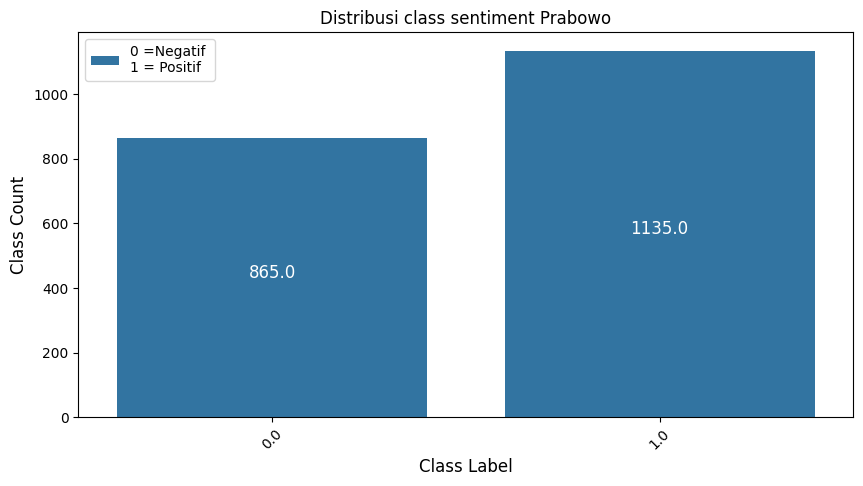

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count label positive and negative
plt.figure(figsize=(10,5))
ax = sns.countplot(x='label', data=data_clean_prabowo, label='0 =Negatif \n1 = Positif')
# Add annotations (counts) to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()/2), ha='center', fontsize=12, color='white')
plt.title('Distribusi class sentiment Prabowo', fontsize=12)
plt.ylabel('Class Count', fontsize=12)
plt.xlabel('Class Label', fontsize=12)
plt.xticks(rotation=45)
ax.legend()

### Anies

In [31]:
# Load dataset
file_path = 'tweets-data\\anies_27oct.csv'
rawdf_anies = pd.read_csv(file_path, delimiter=";")

rawdf_anies.head(2)

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
0,Fri Oct 27 23:44:28 +0000 2023,1718051067156681006,"@awemany Ada cermin dirumahmu, tolong ngaca du...",0,0,0,0,in,1707435734,1717718443775176882,zuhripuding,https://twitter.com/zuhripuding/status/1718051...
1,Fri Oct 27 23:44:12 +0000 2023,1718051000140038647,@awemany Abang satu ini memarahi pendukung Ani...,0,0,0,0,in,1527861644399091712,1717718443775176882,mandaro_alam,https://twitter.com/mandaro_alam/status/171805...


In [32]:
# Make a new Dataframe
df_anies = pd.DataFrame({'username': rawdf_anies['username'],
                          'tweet': rawdf_anies['full_text']})
df_anies.head(2)

,username,tweet
0,zuhripuding,"@awemany Ada cermin dirumahmu, tolong ngaca du..."
1,mandaro_alam,@awemany Abang satu ini memarahi pendukung Ani...


In [33]:
# Dataframe Preparation

# Remove duplicates username
df_anies = df_anies.drop_duplicates(subset='username', keep='first')

# Random 2000 data
df_anies = df_anies.sample(n=2000, random_state=42)

# Reset index
df_anies = df_anies.reset_index(drop=True)
df_anies

,username,tweet
0,qordenputih,pak Anies berusaha untuk selalu melakukan yang...
1,arifin_karim1,"@alisyarief Ini bukan masalah nyali,tapi meman..."
2,pmutia2,oke next. gue suka anies. tp untuk presiden ta...
3,XRagina,luar biasa pak Anies berusaha keras memberikan...
4,BurdiaSudrajad,Semoga program-program Anies bermanfaat untuk ...
...,...,...
1995,ZaenalA36526821,Anies Muhaimin Tegak Lurus Bersama Rakyat #AMI...
1996,papanyaarin,@Outstandjing Setidaknya Anies sudah pernah me...
1997,morjimin,Anies Berusaha keras agar rakyatnya dapat kehi...
1998,AyudiaSulistia,"Dengan Anies, suara anak muda pasti didengar d..."


In [34]:
# Data Preprocessing
df_anies['clean_tweet'] = df_anies['tweet'].apply(clean_tweet)                  # Remove Punctuation
df_anies['clean_tweet'] = df_anies['clean_tweet'].apply(tokenize)               # Tokenizer
df_anies['clean_tweet'] = df_anies['clean_tweet'].apply(remove_stopwords_eng)   # Remove ENG Stopword
df_anies['clean_tweet'] = df_anies['clean_tweet'].apply(remove_stopwords_id)    # Remove ID Stopword
df_anies['clean_tweet'] = df_anies['clean_tweet'].apply(stem_text)              # Stemming

df_anies.head(2)

,username,tweet,clean_tweet
0,qordenputih,pak Anies berusaha untuk selalu melakukan yang...,pak anies usaha selalu laku baik buat indonesi...
1,arifin_karim1,"@alisyarief Ini bukan masalah nyali,tapi meman...",ini bukan masalah nyali memang skenario untuk ...


In [35]:
# Make a new Dataframe
data_clean_anies = df_anies.copy()
data_clean_anies = data_clean_anies.drop(['tweet','username'], axis=1)
data_clean_anies = data_clean_anies.astype({'clean_tweet' : 'string'})

# Switch column order
data_clean_anies = data_clean_anies[['clean_tweet']]

# Save to csv
data_clean_anies.to_csv('data_clean_anies.csv', index=False)
display(data_clean_anies)
display(data_clean_anies.dtypes)

,clean_tweet
0,pak anies usaha selalu laku baik buat indonesi...
1,ini bukan masalah nyali memang skenario untuk ...
2,oke next gue suka anies tp presiden tahun ngga...
3,luar biasa pak anies usaha keras beri program ...
4,moga program program anies manfaat seluruh rakyat
...,...
1995,anies muhaimin tegak lurus sama rakyat aminteg...
1996,tidak anies pernah jalan program di pulau ribu...
1997,anies usaha keras rakyat hidup lebih baik anie...
1998,dengan anies suara anak muda dengar harga


clean_tweet    string[python]
dtype: object

In [36]:
# Prediction

for i in range(0,len(data_clean_anies)):  
    new_text = [data_clean_anies['clean_tweet'][i]]
    new_text_tfidf = func_tfidf.transform(new_text)
    predictions = text_classifier_svm.predict(new_text_tfidf)
    
    # Add data to dataframe
    data_clean_anies.loc[i, 'label'] = predictions

data_clean_anies

,clean_tweet,label
0,pak anies usaha selalu laku baik buat indonesi...,1.0
1,ini bukan masalah nyali memang skenario untuk ...,1.0
2,oke next gue suka anies tp presiden tahun ngga...,0.0
3,luar biasa pak anies usaha keras beri program ...,1.0
4,moga program program anies manfaat seluruh rakyat,1.0
...,...,...
1995,anies muhaimin tegak lurus sama rakyat aminteg...,0.0
1996,tidak anies pernah jalan program di pulau ribu...,1.0
1997,anies usaha keras rakyat hidup lebih baik anie...,1.0
1998,dengan anies suara anak muda dengar harga,1.0


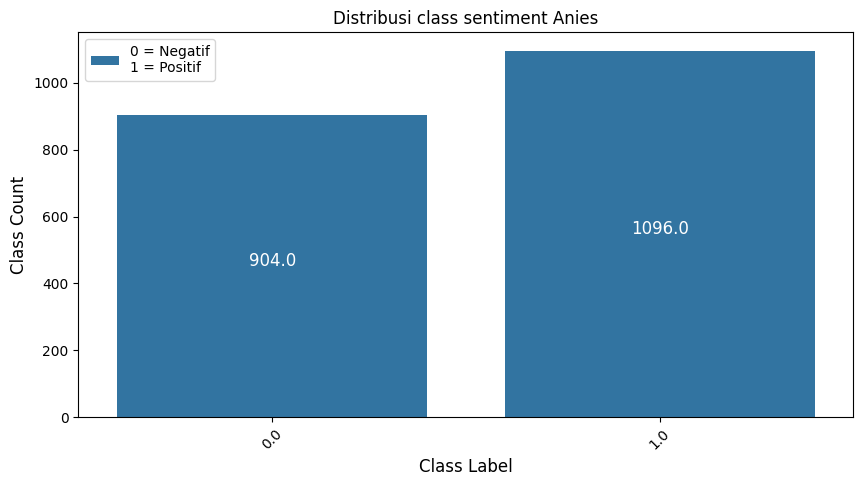

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count label positive and negative
plt.figure(figsize=(10,5))
ax = sns.countplot(x='label', data=data_clean_anies, label='0 = Negatif\n1 = Positif')
# Add annotations (counts) to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()/2), ha='center', fontsize=12, color='white')
plt.title('Distribusi class sentiment Anies', fontsize=12)
plt.ylabel('Class Count', fontsize=12)
plt.xlabel('Class Label', fontsize=12)
plt.xticks(rotation=45)
ax.legend()

### Ganjar

In [38]:
# Load dataset
file_path = 'tweets-data\ganjar_27oct.csv'
rawdf_ganjar = pd.read_csv(file_path, delimiter=";")

rawdf_ganjar.head(2)

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
0,Fri Oct 27 23:41:37 +0000 2023,1718050346193522940,@Prihati_utami Alhamdulillah Bu Yenny Wahid me...,0,0,0,0,in,1451197461691699207,1717821169020342313,istmeeta,https://twitter.com/istmeeta/status/1718050346...
1,Fri Oct 27 23:41:36 +0000 2023,1718050342821392667,@otnayram_me Terima kasih atas dukungan nya Ye...,0,0,0,1,in,1427318081794154512,1717807930572222508,MShoqrun,https://twitter.com/MShoqrun/status/1718050342...


In [39]:
# Make a new Dataframe
df_ganjar = pd.DataFrame({'username': rawdf_ganjar['username'],
                          'tweet': rawdf_ganjar['full_text']})
df_ganjar.head(2)

,username,tweet
0,istmeeta,@Prihati_utami Alhamdulillah Bu Yenny Wahid me...
1,MShoqrun,@otnayram_me Terima kasih atas dukungan nya Ye...


In [40]:
# Dataframe Preparation

# Remove duplicates username
df_ganjar = df_ganjar.drop_duplicates(subset='username', keep='first')

# Random 2000 data
df_ganjar = df_ganjar.sample(n=2000, random_state=42)

# Reset index
df_ganjar = df_ganjar.reset_index(drop=True)
df_ganjar

,username,tweet
0,Saprol01035041,@ganjarpranowo All in ganjar
1,nadivachw,@SINDOnews gagasan gagasan ganjar-mahfud meman...
2,jaylasti,@ganjarpranowo Semoga diberi kesehatan Pak Gan...
3,irhamnapermana,@M45Broo Di 2019 elektabilitas serta kepuasan ...
4,PoernamaRival,@IDNTimes Pak ganjar di terima di semua kalang...
...,...,...
1995,surupsrengenge,@Twillight_Loid koreksi: *ke arah pemahaman yg...
1996,stivenakbarr,@okezonenews optimis menang Ganjar Mahfud♥️
1997,KalselForGanjar,Ganjar mengisi kuliah umum di Kampus Pascasarj...
1998,rahmani_ima,@udit_kh @mohmahfudmd Mungkinkah tadinya berha...


In [41]:
# Data Preprocessing
df_ganjar['clean_tweet'] = df_ganjar['tweet'].apply(clean_tweet)                  # Remove Punctuation
df_ganjar['clean_tweet'] = df_ganjar['clean_tweet'].apply(tokenize)               # Tokenizer
df_ganjar['clean_tweet'] = df_ganjar['clean_tweet'].apply(remove_stopwords_eng)   # Remove ENG Stopword
df_ganjar['clean_tweet'] = df_ganjar['clean_tweet'].apply(remove_stopwords_id)    # Remove ID Stopword
df_ganjar['clean_tweet'] = df_ganjar['clean_tweet'].apply(stem_text)              # Stemming

df_ganjar.head(2)

,username,tweet,clean_tweet
0,Saprol01035041,@ganjarpranowo All in ganjar,ganjar
1,nadivachw,@SINDOnews gagasan gagasan ganjar-mahfud meman...,gagas gagas ganjar mahfud memang top mantap best


In [42]:
# Make a new Dataframe
data_clean_ganjar = df_ganjar.copy()
data_clean_ganjar = data_clean_ganjar.drop(['tweet','username'], axis=1)
data_clean_ganjar = data_clean_ganjar.astype({'clean_tweet' : 'string'})

# Switch column order
data_clean_ganjar = data_clean_ganjar[['clean_tweet']]

# Save to csv
data_clean_ganjar.to_csv('data_clean_anies.csv', index=False)
display(data_clean_ganjar)
display(data_clean_ganjar.dtypes)

,clean_tweet
0,ganjar
1,gagas gagas ganjar mahfud memang top mantap best
2,moga beri sehat pak ganjar seluruh warga lampung
3,di 2019 elektabilitas puas publik thdp pk jkw ...
4,pak ganjar terima semua kalang keren saat bang...
...,...
1995,koreksi arah paham yg sempit sekarang gw cuman...
1996,optimis menang ganjar mahfud
1997,ganjar isi kuliah umum kampus pascasarjana uni...
1998,mungkin tadi harap pak ganjar loncat psi spt b...


clean_tweet    string[python]
dtype: object

In [46]:
# Prediction

for i in range(0,len(data_clean_ganjar)):  
    new_text = [data_clean_ganjar['clean_tweet'][i]]
    new_text_tfidf = func_tfidf.transform(new_text)
    predictions = text_classifier_svm.predict(new_text_tfidf)
    
    # Add data to dataframe
    data_clean_ganjar.loc[i, 'label'] = predictions

data_clean_ganjar

,clean_tweet,label
0,ganjar,0.0
1,gagas gagas ganjar mahfud memang top mantap best,1.0
2,moga beri sehat pak ganjar seluruh warga lampung,0.0
3,di 2019 elektabilitas puas publik thdp pk jkw ...,0.0
4,pak ganjar terima semua kalang keren saat bang...,1.0
...,...,...
1995,koreksi arah paham yg sempit sekarang gw cuman...,0.0
1996,optimis menang ganjar mahfud,1.0
1997,ganjar isi kuliah umum kampus pascasarjana uni...,1.0
1998,mungkin tadi harap pak ganjar loncat psi spt b...,0.0


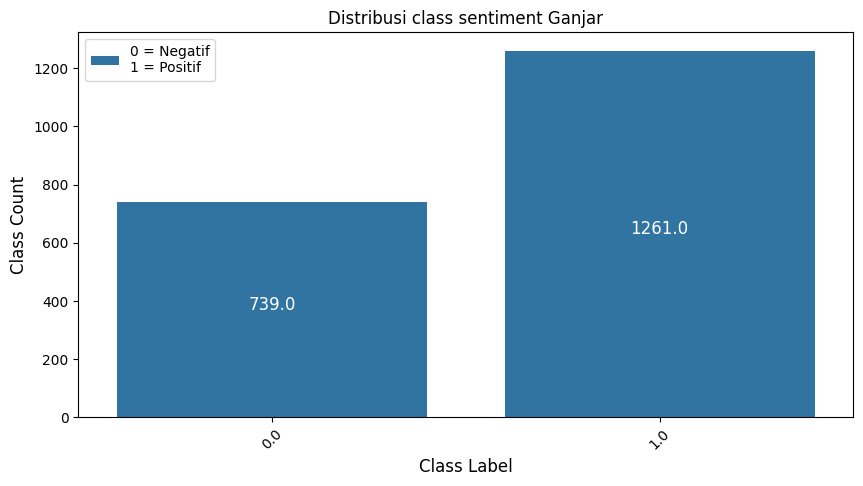

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count label positive and negative
plt.figure(figsize=(10,5))
ax = sns.countplot(x='label', data=data_clean_ganjar, label='0 = Negatif\n1 = Positif')
# Add annotations (counts) to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()/2), ha='center', fontsize=12, color='white')
plt.title('Distribusi class sentiment Ganjar', fontsize=12)
plt.ylabel('Class Count', fontsize=12)
plt.xlabel('Class Label', fontsize=12)
plt.xticks(rotation=45)
ax.legend()